### Imports

In [1]:
import shutil
import importlib
import cv2
shutil.rmtree('__pycache__')
import Player
importlib.reload(Player)
from Player import get_player_boxes
from Ball import BallDetector
import detect_court_net
import Transmit
import matplotlib.pyplot as plt
import numpy as np
import random

read the video by the videostream class

In [2]:
path_to_video = 'cocog.mp4'

In [3]:
vs = Transmit.VideoStream()
frames = vs.read_video(path_to_video)

load the balls and initiate the ball detector

In [4]:
bd = BallDetector(path_weights='weights/model.3')



layer24 output shape: 256 360 640
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9, 360, 640)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 360, 640)      5248      
                                                                 
 activation (Activation)     (None, 64, 360, 640)      0         
                                                                 
 batch_normalization (Batch  (None, 64, 360, 640)      2560      
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 360, 640)      36928     
                                                                 
 activation_1 (Activation)   (None, 64, 360, 640)      0         
                       

setting the resolution of video

In [5]:
bd.output_height = vs.output_height
bd.output_width = vs.output_width

detect balls

In [6]:
ballpoints = bd.find_ball_points(frames)
ballpoints = bd.postprocess_points(ballpoints)
# bd.draw_trajectory_pride(frames, ballpoints, 'balltestonly.mp4') #if you need to only see the balls

1/1 [==============================] - 1s 1s/step


find players

In [7]:
players = Player.get_player_boxes(frames)

just see the transmitted version

In [8]:
courtpoints = detect_court_net.detect_points(frames[1], False)
# img = detect_court_net.detect_points(frames[1], True)
# print(courtpoints, frames[0].shape, len(frames))
print(courtpoints)

([[373, 147], [373, 218], [374, 698], [374, 628], [276, 256], [277, 424], [278, 592], [114, 286], [114, 321], [111, 565], [112, 529], [151, 306], [148, 424], [145, 542], [169, 424]], [[166, 255], [166, 595]])


In [9]:
print(len(players), len(ballpoints), len(frames), frames[0].shape)
print(players[0], ballpoints[0], courtpoints)

192 193 193 (480, 854, 3)
[(335, 292, 40, 62), (506, 64, 25, 40)] [375, 295] ([[373, 147], [373, 218], [374, 698], [374, 628], [276, 256], [277, 424], [278, 592], [114, 286], [114, 321], [111, 565], [112, 529], [151, 306], [148, 424], [145, 542], [169, 424]], [[166, 255], [166, 595]])


In [10]:
while len(players) != len(frames):
    players.insert(0, [])

In [11]:
print(path_to_video, frames[0].shape)

cocog.mp4 (480, 854, 3)


In [12]:
cap = cv2.VideoCapture(path_to_video) 
fourcc = cv2.VideoWriter_fourcc('H','2','6','4')
out = cv2.VideoWriter("gg_ff_out.mp4", fourcc, cap.get(cv2.CAP_PROP_FPS), (frames[0].shape[1],frames[0].shape[0]))
for i, frame in enumerate(frames):
    for bbox in players[i]:
        Player.drawBox(frame, bbox)
    # print(i, ballpoints[i][0])
    Player.drawBox(frame, (ballpoints[i][0], ballpoints[i][1], 10, 10))
    keypoints, netpoints = courtpoints
    for point in keypoints + netpoints:
        Player.drawBox(frame, (point[1], point[0], 10, 10))
    
    out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()

[[373, 147], [373, 218], [374, 698], [374, 628], [276, 256], [277, 424], [278, 592], [114, 286], [114, 321], [111, 565], [112, 529], [151, 306], [148, 424], [145, 542], [169, 424], [166, 255], [166, 595]] 17


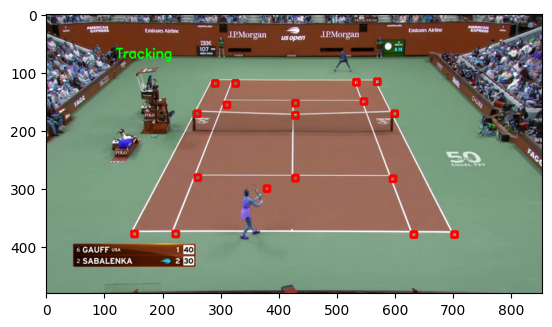

In [13]:
plt.imshow(frames[0])
all_courtpoints = courtpoints[0] + courtpoints[1]
print(all_courtpoints, len(all_courtpoints))

In [55]:
path_2d_court = 'tennis_2d_2.png'

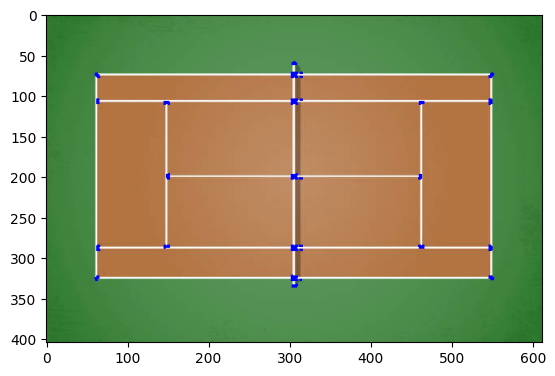

In [56]:
img = cv2.imread(path_2d_court)
plt.imshow(img[:,:,::-1])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)
img[dst>0.01*dst.max()]=[0,0,255]
plt.imshow(img)
# print((dst>0.01*dst.max()).shape)
kpts = np.argwhere(dst>0.01*dst.max())
# print(len(kpts))

In [57]:
# all_court2dpoints = [[67, 63] , [138, 63] , [545, 63], [474, 63] , [138, 288], [306, 288],
#                  [474, 288] , [67, 960], [138, 960], [545, 960], [474, 960], [138, 738],
#                  [306, 738] , [474, 738], [306, 512], [67, 512], [545 , 512]]
all_court2dpoints = [[74, 61] , [106, 61] , [324, 61], [287, 61] , [106, 148], [199, 148],
                 [287, 148] , [74, 549], [106, 549], [324, 549], [287, 549], [106, 462],
                 [199, 462] , [287, 462], [199, 306], [74, 306], [324 , 306]]
# all_court2dpoints = [[327, 453] , [416, 453] , [1329, 453], [1241, 453] , [416, 851], [830, 851],
                 # [1241, 851] , [327, 2034], [416, 2034], [1329, 2034], [1241, 2034], [416, 1638],
                 # [830, 1638] , [1241, 1638], [830, 1244], [327, 1244], [1329 , 1244]]

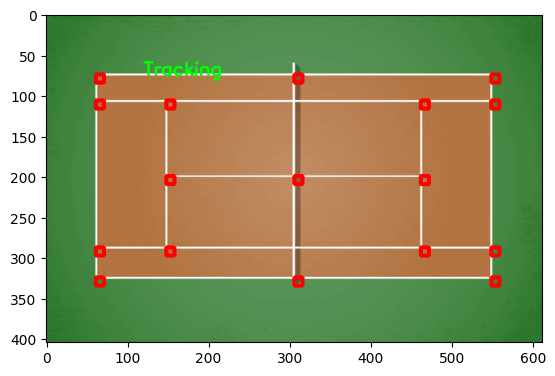

In [58]:
img = cv2.imread(path_2d_court)
for pt in all_court2dpoints:
    Player.drawBox(img, (pt[1], pt[0], 10, 10))
plt.imshow(img)

In [59]:
np_all_courtpoints = np.array(all_courtpoints)
np_all_court2dpoints = np.array(all_court2dpoints)

# zipped_points = list(zip(all_courtpoints, all_court2dpoints))
# random.shuffle(zipped_points)
# np_all_courtpoints, np_all_court2dpoints = zip(*zipped_points)
# np_all_courtpoints = np.array(np_all_courtpoints)
# np_all_court2dpoints = np.array(np_all_court2dpoints)

# np_all_court2dpoints[:,1] -= 30

H, _ = cv2.findHomography(np_all_courtpoints, np_all_court2dpoints)
print(H)

[[ 3.10907177e+00  2.81290315e+00 -9.76816356e+02]
 [-4.63268053e+00  2.56573426e-02  2.09129611e+03]
 [ 1.55091154e-02  2.86409570e-04  1.00000000e+00]]


In [60]:
error = 0
for i,p in enumerate(all_courtpoints):
    pp = H @ [p[0], p[1], 1]
    pp /= pp[-1]
    print(pp[:2], all_court2dpoints[i], pp[:2] - all_court2dpoints[i])
    error +=  np.sum((pp[:2] - all_court2dpoints[i])**2)
print(error**0.5)

[87.35374005 53.76853391] [74, 61] [13.35374005 -7.23146609]
[116.26129483  53.87489407] [106, 61] [10.26129483 -7.12510593]
[307.04052932  53.79500562] [324, 61] [-16.95947068  -7.20499438]
[279.71388617  53.69221659] [287, 61] [-7.28611383 -7.30778341]
[112.32891383 153.02008837] [106, 148] [6.32891383 5.02008837]
[198.81400914 151.16344586] [199, 148] [-0.18599086  3.16344586]
[283.2912208  149.34990815] [287, 148] [-3.7087792   1.34990815]
[ 63.89865827 551.06484991] [74, 549] [-10.10134173   2.06484991]
[ 98.0986122  549.44733611] [106, 549] [-7.9013878   0.44733611]
[332.10899359 551.9878741 ] [324, 549] [8.10899359 2.9878741 ]
[297.53022423 549.07089629] [287, 549] [10.53022423  0.07089629]
[103.04709641 408.10766993] [106, 462] [ -2.95290359 -53.89233007]
[197.84588731 414.58194982] [199, 462] [ -1.15411269 -47.41805018]
[293.35376472 421.10465675] [287, 462] [  6.35376472 -40.89534325]
[198.07402458 352.50755241] [199, 306] [-0.92597542 46.50755241]
[ 70.34311563 364.30333854]

In [61]:
img = cv2.imread(path_2d_court)
cap = cv2.VideoCapture(path_to_video) 
fourcc = cv2.VideoWriter_fourcc('H','2','6','4')
out = cv2.VideoWriter("homography_map.mp4", fourcc, cap.get(cv2.CAP_PROP_FPS), (img.shape[1], img.shape[0]))
for i in range(len(frames)):
    frame = img.copy()
    # print(players[i])
    for x, y, w, h in players[i]:
        x_middle = x + w // 2
        y_middle = y + h // 2
        point_h = H @ [y_middle, x_middle, 1]
        point_h = point_h / point_h[-1]
        # print(point_h)
        cv2.circle(frame, center=(round(point_h[1]), round(point_h[0])), radius=5, color=(0, 0, 255), thickness=-1)
    # print(i, ballpoints[i][0])
    ball_h = H @ [ballpoints[i][1], ballpoints[i][0], 1]
    ball_h = ball_h / ball_h[-1]
    cv2.circle(frame, center=(round(ball_h[1]), round(ball_h[0])), radius=5, color=(0, 0, 255), thickness=-1)    
    out.write(frame)
    # print('yooooooooooo')

cap.release()
out.release()
cv2.destroyAllWindows()